In [1]:
import sys
import math 
import numpy as np
from skimage import data,io,filters,transform
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
from scipy.stats import norm

In [2]:
current_pos = (70,70,45/360*2*math.pi) # x,y,theta
map_path = "true_map2.jpg"

In [3]:
def get_beam(pos):
    true_map = io.imread(map_path)
    map_height, map_width, map_depth = true_map.shape
    # cast lidar beam
    dx = math.cos(-pos[2])
    dy = math.sin(-pos[2])
    for r in range(1000):
        x_ = int(pos[0] + r*dx)
        y_ = int(pos[1] + r*dy)

        # clip to map
        if x_ < map_width and y_ < map_height and x_ >= 0 and y_ >= 0:
            if sum(true_map[y_,x_]) > 570:
                # wall
                return r
        else:
            # lidar data reaches end of map
            break
    return None


In [4]:
def draw_pos():
    true_map = io.imread(map_path)
    map_height, map_width, map_depth = true_map.shape


    # cast lidar rays
    for ang_ in [-80,-40,-20,0,20,40,80]:
        for r in range(1000):
            x_ = int(current_pos[0] + r*math.cos(-current_pos[2]+ang_/360*2*math.pi))
            y_ = int(current_pos[1] + r*math.sin(-current_pos[2]+ang_/360*2*math.pi))

            # clip to map
            if x_ < map_width and y_ < map_height and x_ >= 0 and y_ >= 0:
                if sum(true_map[y_,x_]) > 570:
                    # wall
                    true_map[y_,x_] = [0,255,0]
                    break
                else:
                    true_map[y_,x_] = [0,50,0]
            else:
                # lidar data reaches end of map
                break

    true_map[current_pos[1],current_pos[0]] = [255,0,0]
    io.imshow(true_map)
    io.show()

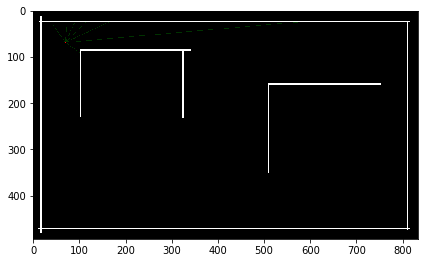

63

In [5]:
draw_pos()
get_beam(current_pos)

In [6]:
def gauss(n=11,sigma=1):
    r = range(-int(n/2),int(n/2)+1)
    return [1 / (sigma * math.sqrt(2*math.pi)) * math.exp(-float(x)**2/(2*sigma**2)) for x in r]

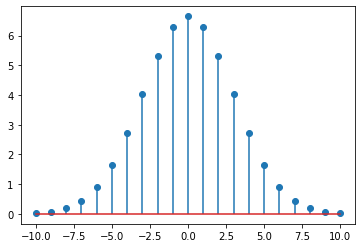

In [7]:
hlf_num_pit = 10

plt.stem(range(-hlf_num_pit,hlf_num_pit+1),norm.pdf(range(-hlf_num_pit,hlf_num_pit+1), 0, 3)*50)
plt.show()

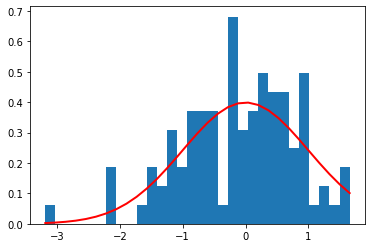

In [8]:
mu = 0
sigma = 1
s= np.random.normal(mu, sigma, 100)
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [15]:
def get_beam_probability(pos):
    r_ = []
    for s_ in s:
        r = get_beam((pos[0], pos[1], pos[2]+(s_/360*2*math.pi)))
        if r is not None:
            r_.append(r+np.random.normal(0, .05)) 

    count, bins, ignored = plt.hist(r_, 12)
    plt.close()

    count = count/sum(count)

    index = np.argmin(np.abs(np.array(bins)-get_beam(pos)))
    pr = count[min(index, len(count)-1)]
    #print(get_beam(pos), pr)
    #plt.stem(bins[:-1],count)
    #plt.show()
    return pr

In [16]:
def get_pose_pr(pos):
    beam_pr = []
    for ang_ in [-80,-40,-20,0,20,40,80]:
        beam_pr.append(get_beam_probability((pos[0], pos[1], pos[2]+(ang_/360*2*math.pi))))
    pr = np.sqrt(np.mean(np.array(beam_pr)**2))#sum(beam_pr) / len(beam_pr)
    return pr
#get_pose_pr(current_pos)

In [17]:
pd_map = io.imread(map_path)
map_height, map_width, map_depth = pd_map.shape


for y_ in [-10,-5,0,5,10]: 
    for x_ in [-10,-5,0,5,10]: 
        guess_pos = (current_pos[0]+x_,current_pos[1]+y_,current_pos[2])

        pd = get_pose_pr(guess_pos)
        print(x_,y_,pd)
        pd_map[guess_pos[1],guess_pos[0]] = [0,255*pd,255*pd]
        break 
    break
#pd_map[current_pos[1],current_pos[0]] = [255,0,0]
#io.imshow(pd_map)
fig=plt.figure(figsize=(12,8), dpi=500)
plt.imshow(pd_map)
plt.show()

148 ns ± 2.01 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
151 ns ± 2.13 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
151 ns ± 1.73 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
148 ns ± 1.69 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
148 ns ± 1.76 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


KeyboardInterrupt: 